In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import yaml

In [2]:
%run ./src/database.py
%run ./src/util.py
%run ./src/data_preprocessing.py
%run ./src/feature_engineering.py
%run ./src/visualisation.py

In [3]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1

In [4]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)

# Preprocessing

In [5]:
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']

In [6]:
# Read source data (Pre_cruise, Post_cruise) with removal of duplicates
ds_pre_cruise = Database(DATA_PATH)
df_pre_cruise = ds_pre_cruise.db_read(yaml_data['databases'][PRE_CRUISE_DB])

ds_post_cruise = Database(DATA_PATH)
df_post_cruise = ds_post_cruise.db_read(yaml_data['databases'][POST_CRUISE_DB])

In [7]:
# Merge Pre_cruise and Post_cruise to form df_cruise with Index as the key
df_cruise = merge_dataframe (df_pre_cruise, df_post_cruise)

In [8]:
# Split composite field to increase interpretability
split_column(df_cruise, 'Source of Traffic', ['Source', 'Traffic'], ' - ')

split_column(df_cruise, 'Cruise Distance', ['Distance', 'Dist_Metrics'], ' ')
df_cruise['Distance'] = pd.to_numeric(df_cruise['Distance'], errors='coerce').astype('float')

In [9]:
# Remove IDs columns as in general they will have no predictive power
remove_col(df_cruise,['Ext_Intcode_x', 'Ext_Intcode_y'])

In [10]:
# Split composite field to increase interpretability
convert_object_to_datetime (df_cruise, ['Date of Birth'],['%d/%m/%Y'])
convert_object_to_datetime (df_cruise, ['Logging'],['%d/%m/%Y %H:%M'])

In [11]:
# Removal of columns with high missing values
dp_remove_columns_with_high_missing(df_cruise, 0.4)

Index(['WiFi', 'Entertainment'], dtype='object')


In [12]:
# Removal of rows from Continuous variable which has missing value 
remove_missing_value(df_cruise,['Date of Birth', TARGET_VARIABLE, 'Distance','Logging'])

In [13]:
dp_replace_value(df_cruise, ["Gender"], 'F', 'Female', True)
dp_replace_value(df_cruise, ["Gender"], 'm', 'Male', True)

In [14]:
numeric_ordinal_list =['Embarkation/Disembarkation time convenient', 'Ease of Online booking', 'Gate location', 
    'Online Check-in', 'Cabin Comfort', 'Cabin service', 'Baggage handling', 'Port Check-in Service', 
    'Onboard Service', 'Cleanliness']
dp_replace_value(df_cruise, numeric_ordinal_list, 0, None)

In [15]:
dp_replace_value(df_cruise, ["Cruise Name"], 'L', 'Lapras', True)
dp_replace_value(df_cruise, ["Cruise Name"], 'b', 'Blastoise', True)

In [16]:
categorical_ordinal_list  = ['Onboard Wifi Service', 'Onboard Dining Service','Onboard Entertainment']
dp_restrict_val(df_cruise, numeric_ordinal_list, [1, 2, 3, 4, 5])

dp_restrict_val(df_cruise, ["Gender"], ['Female','Male'])
dp_restrict_val(df_cruise, categorical_ordinal_list, ['Not at all important', 'A little important', 
                                                                       'Somewhat important', 'Very important', 
                                                                       'Extremely important'])
dp_restrict_val(df_cruise, ["Cruise Name"], ['Lapras','Blastoise'])
dp_restrict_val(df_cruise, ["Ticket Type"], ['Deluxe','Luxury', 'Standard'])
dp_restrict_val(df_cruise, ["Source"], ['Indirect','Direct'])
dp_restrict_val(df_cruise, ["Dining"], [0.0, 0.1])
dp_restrict_val(df_cruise, ["Traffic"], ['Search Engine','Company Website','Email Marketing','Social Media'])
dp_restrict_val(df_cruise, ["Dist_Metrics"], ['KM','Miles'])

In [17]:
# Label encode non-numeric categorical columns to get numeric values
list_non_numeric_col = ['Gender','Onboard Wifi Service','Onboard Dining Service','Onboard Entertainment','Cruise Name',
                            'Ticket Type','Source','Traffic','Dist_Metrics']
label_encoder(df_cruise,list_non_numeric_col)

In [18]:
# Derive year from date column to enhance model efficiency, mitigate noise
convert_datetime_to_year(df_cruise, ['Date of Birth','Logging'],['Year of Birth','Year of Logging'])

# Feature Engineering

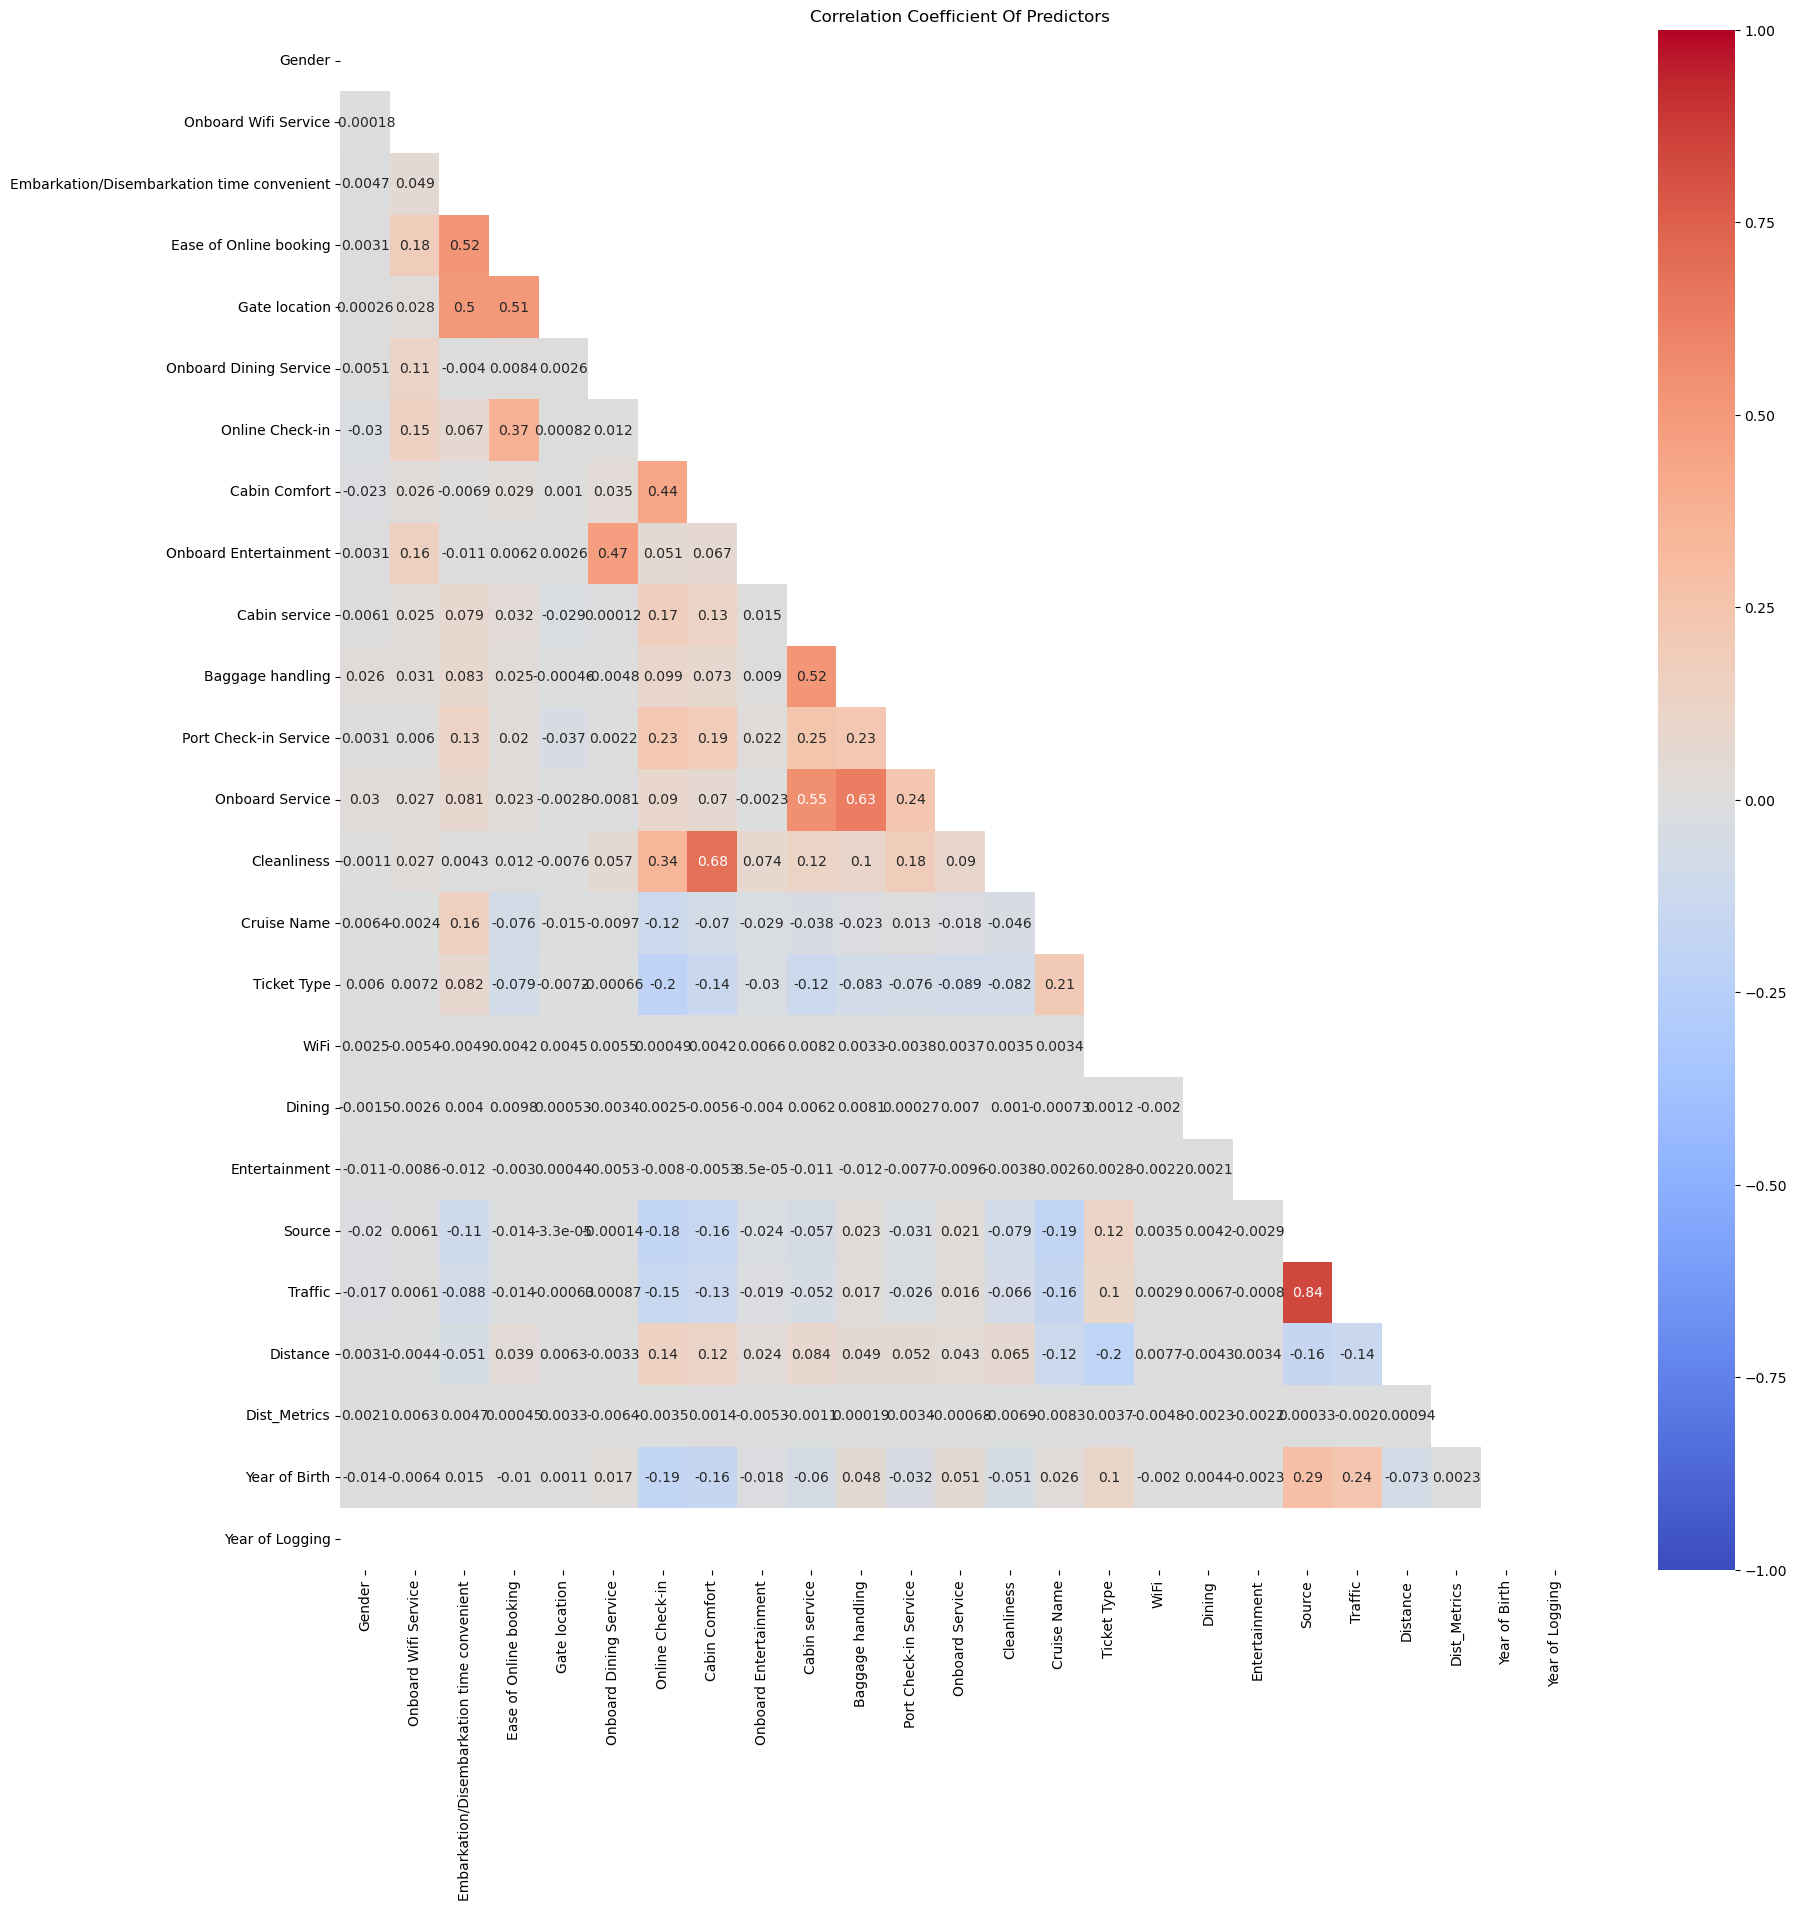

In [19]:
%run ./src/visualisation.py
vs_plot_corr_chart(df_cruise)

In [20]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  70861 non-null  float64
 3   Ease of Online booking                      69648 non-null  float64
 4   Gate location                               73566 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             72783 non-null  float64
 7   Cabin Comfort                               71643 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               75729 non-null  float64
 10  Baggage handli

In [21]:
# Standardise distance by converting Mile to KM
convert_miles_to_KM(df_cruise, "Distance")
df_cruise["Distance"] = abs(df_cruise["Distance"])

In [22]:
# Derive Age from Year of Birth and Year of Logging
calc_year_diff(df_cruise, 'Year of Logging', 'Year of Birth', 'Age')

In [23]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 24 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  70861 non-null  float64
 3   Ease of Online booking                      69648 non-null  float64
 4   Gate location                               73566 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             72783 non-null  float64
 7   Cabin Comfort                               71643 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               75729 non-null  float64
 10  Baggage handli

In [24]:
%run ./src/feature_engineering.py
#### Denote Missing column
denote_missing_col(df_cruise)

['Embarkation/Disembarkation time convenient_missing', 'Ease of Online booking_missing', 'Gate location_missing', 'Online Check-in_missing', 'Cabin Comfort_missing', 'Cabin service_missing', 'Baggage handling_missing', 'Port Check-in Service_missing', 'Onboard Service_missing', 'Cleanliness_missing', 'WiFi_missing', 'Entertainment_missing']
index
2     4
3     3
4     6
6     4
10    4
Name: tot_missing_col, dtype: int64


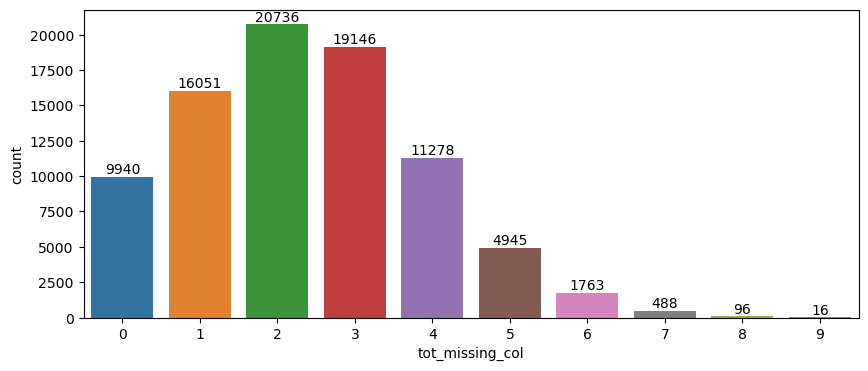

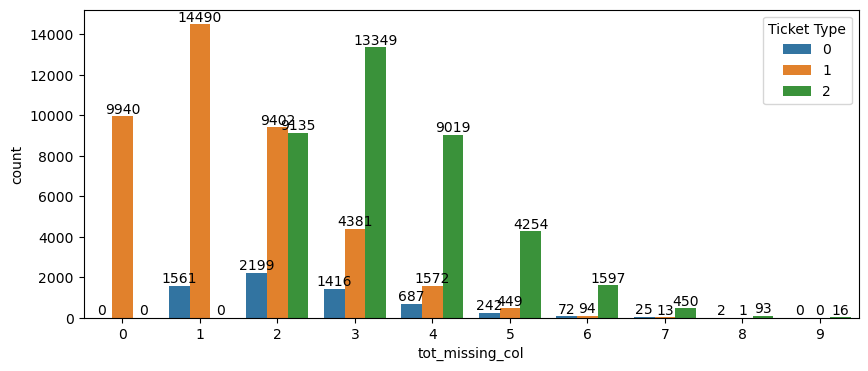

In [25]:
%run ./src/visualisation.py

missing_list = ['tot_missing_col']

df_cruise[missing_list]

vs_countplot_both(df_cruise, 'tot_missing_col')

In [26]:
df_cruise['tot_missing_col'].describe()

count    84459.000000
mean         2.364508
std          1.531131
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          9.000000
Name: tot_missing_col, dtype: float64

#### Gender

In [27]:
# impute_missing_value(df_cruise,  impute_type="random", col_list=['Gender'], none_val=2)

#### Embarkation/Disembarkation time convenient

In [28]:
# vs_countplot_both(df_cruise, 'Embarkation/Disembarkation time convenient')

In [29]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  70861 non-null  float64
 3   Ease of Online booking                      69648 non-null  float64
 4   Gate location                               73566 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             72783 non-null  float64
 7   Cabin Comfort                               71643 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               75729 non-null  float64
 10  Baggage handli

In [30]:
impute_missing_value(df_cruise, impute_type="mean")

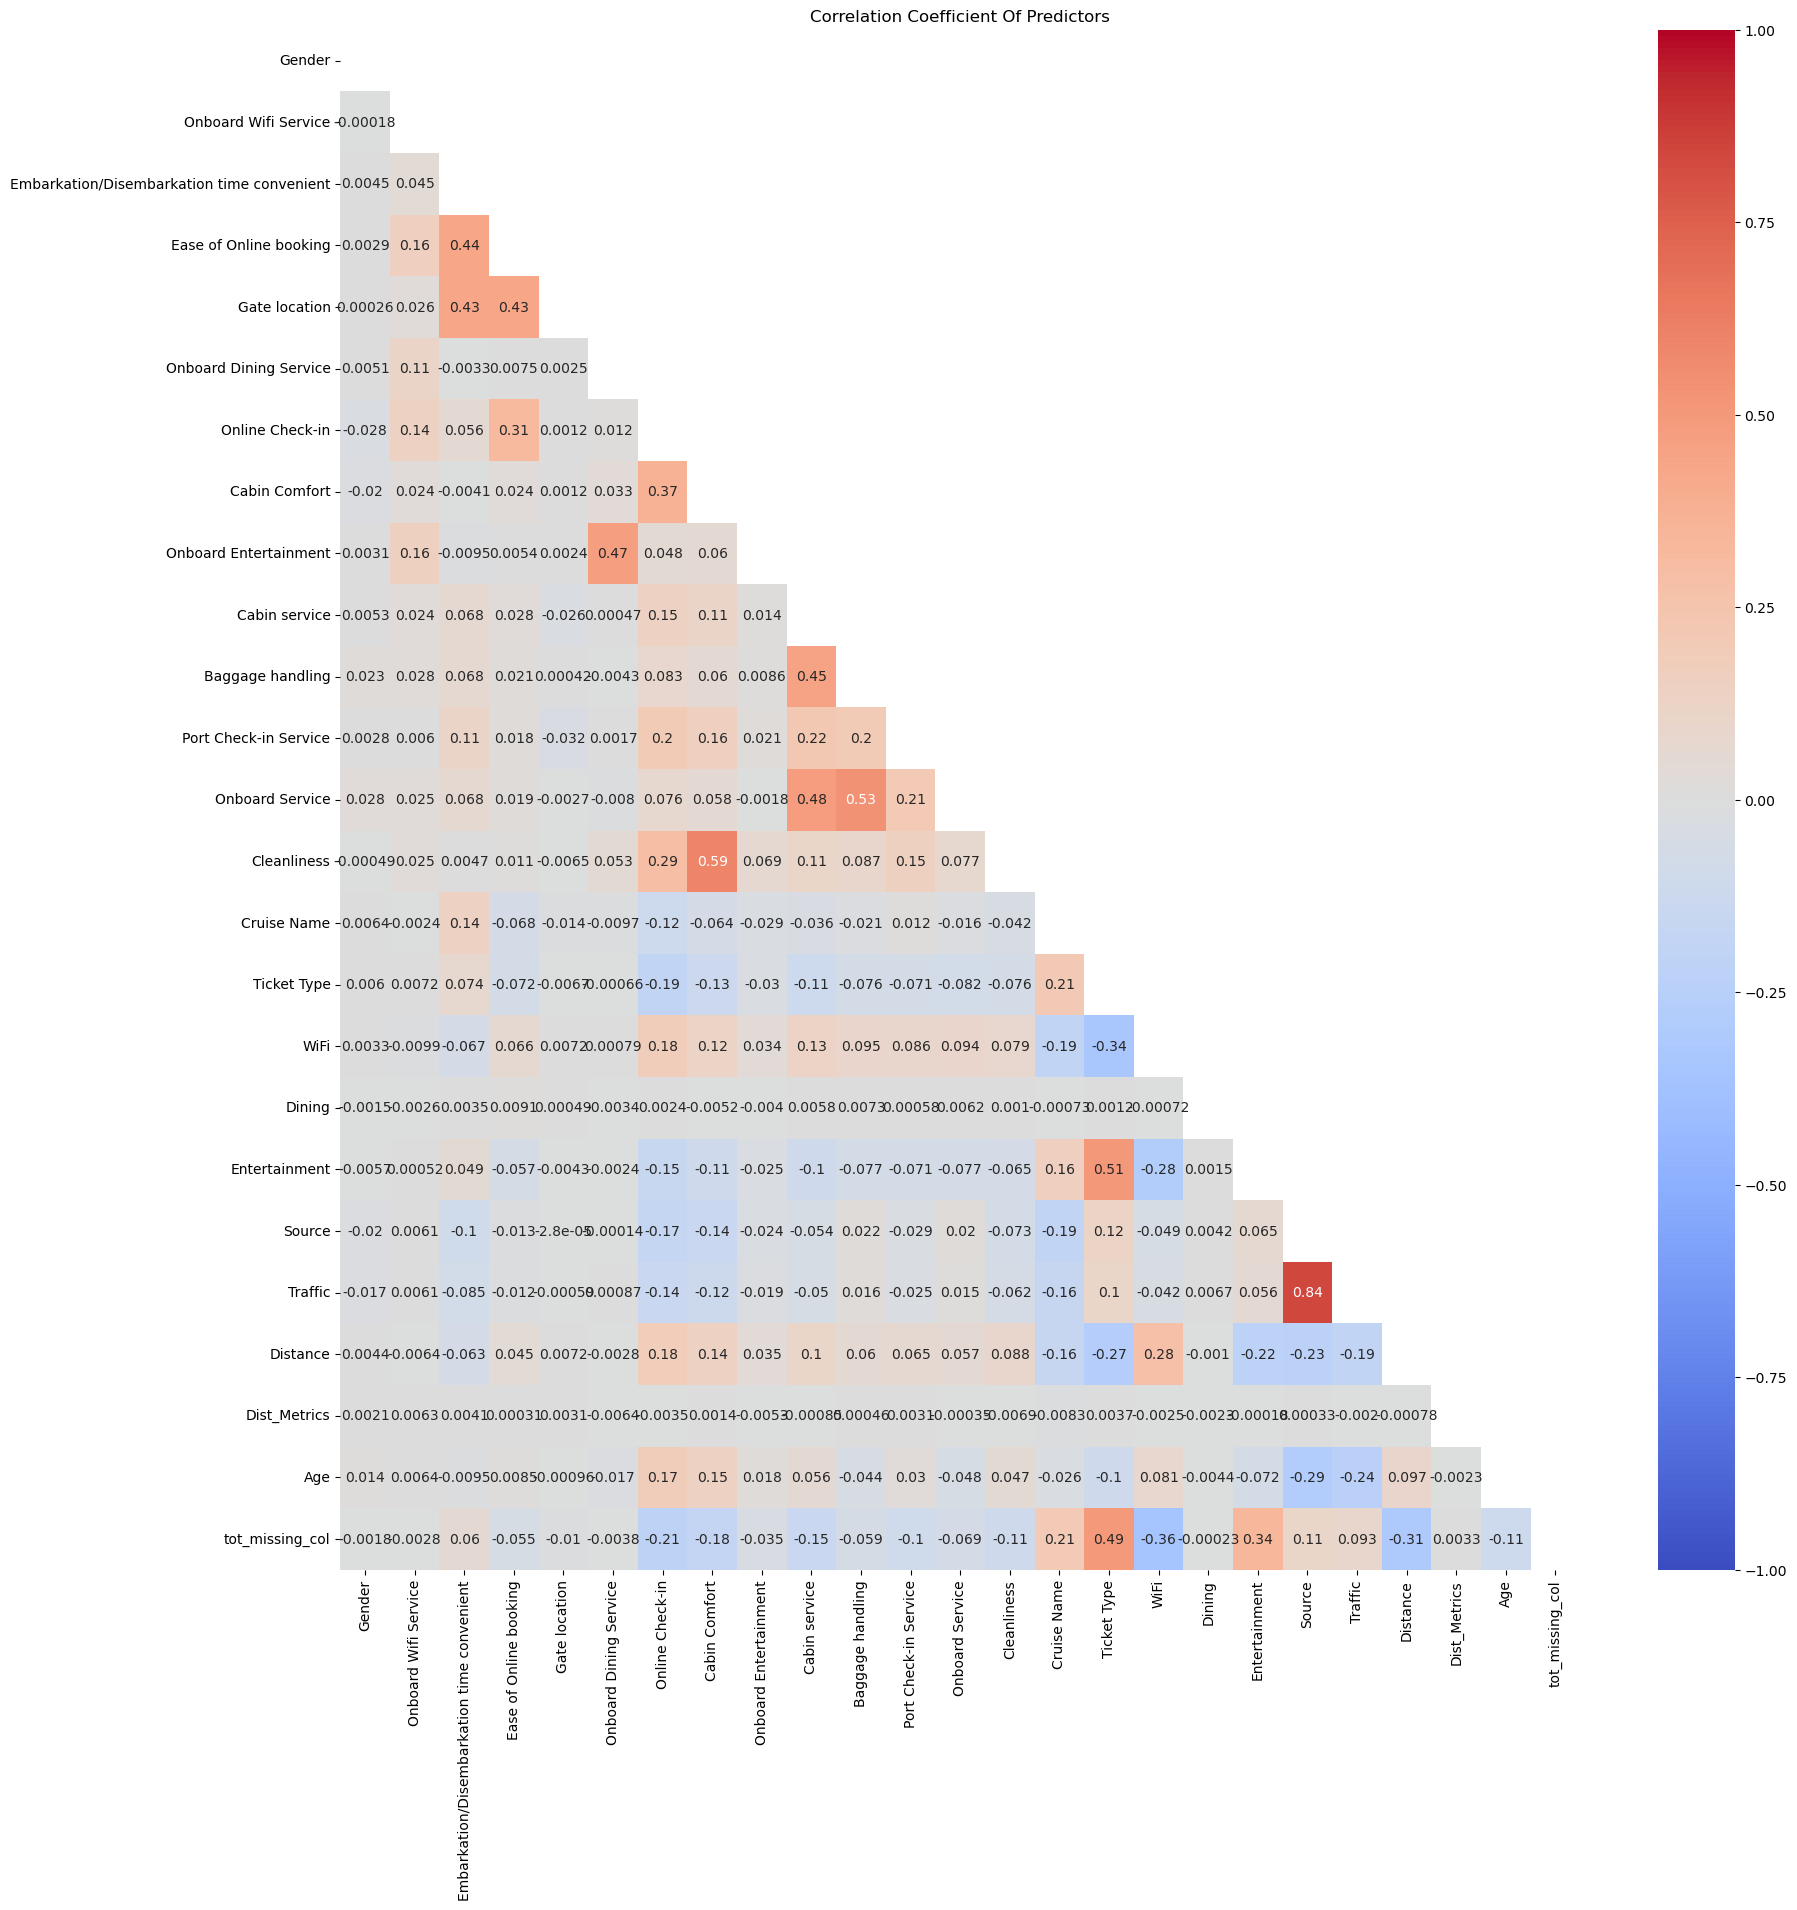

In [31]:
vs_plot_corr_chart(df_cruise)

# Model Building

In [32]:
df_cruise.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84459 entries, 2 to 133745
Data columns (total 25 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Gender                                      84459 non-null  int32  
 1   Onboard Wifi Service                        84459 non-null  int32  
 2   Embarkation/Disembarkation time convenient  84459 non-null  float64
 3   Ease of Online booking                      84459 non-null  float64
 4   Gate location                               84459 non-null  float64
 5   Onboard Dining Service                      84459 non-null  int32  
 6   Online Check-in                             84459 non-null  float64
 7   Cabin Comfort                               84459 non-null  float64
 8   Onboard Entertainment                       84459 non-null  int32  
 9   Cabin service                               84459 non-null  float64
 10  Baggage handli

In [33]:
X = df_cruise.drop([TARGET_VARIABLE],axis=1)
y = df_cruise[TARGET_VARIABLE]

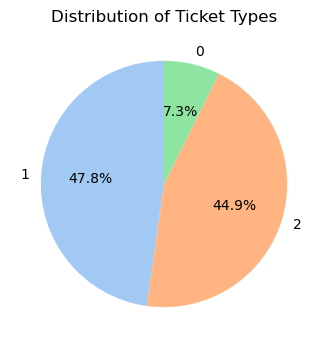

In [34]:
y = pd.DataFrame(y)
vs_pieplot(y, TARGET_VARIABLE)

In [35]:
# Perform SMOTE
X, y = fe_SMOTE(X, y, RANDOM_STATE)

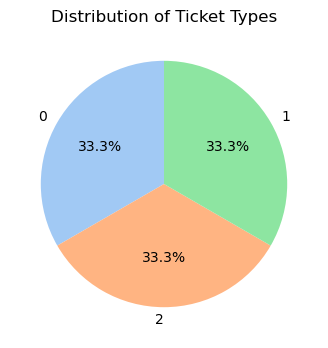

In [36]:
y = pd.DataFrame(y)
vs_pieplot(y, TARGET_VARIABLE)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE , random_state=RANDOM_STATE)
y_train = y_train.values.ravel()

In [ ]:
log_regression = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)
log_regression.fit(X_train, y_train)
y_train_pred_log = log_regression.predict(X_train)
y_test_pred_log = log_regression.predict(X_test)

In [ ]:
# random_forest = RandomForestClassifier()
# random_forest.fit(X_train, y_train)
# y_train_pred_rf = random_forest.predict(X_train)
# y_test_pred_rf = random_forest.predict(X_test)

# Model Evaluation

In [ ]:
from sklearn import metrics
print("Classification report - Train")
print(classification_report(y_train, y_train_pred_log))
print("Classification report - Test")
print(classification_report(y_test, y_test_pred_log))
print(" ")
print("Classification report - Test")
print(confusion_matrix(y_train, y_train_pred_log))
print("Confusion Matrix - Test")
print(confusion_matrix(y_test, y_test_pred_log))
print(" ")
print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_log), '.4f'))
# print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# print(" ")
print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_log), '.4f'))
# print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

print("")


In [ ]:
# from sklearn import metrics
# print("Classification report - Train")
# print(classification_report(y_train, y_train_pred_rf))
# print("Classification report - Test")
# print(classification_report(y_test, y_test_pred_rf))
# print(" ")
# print("Classification report - Test")
# print(confusion_matrix(y_train, y_train_pred_rf))
# print("Confusion Matrix - Test")
# print(confusion_matrix(y_test, y_test_pred_rf))
# print(" ")
# print("Train Accuracy: ",format(metrics.accuracy_score(y_train, y_train_pred_rf), '.4f'))
# # print("Train Precision: ",format(metrics.precision_score(y_train, y_train_pred_log, average='micro'), '.4f'))
# # print("Train Recall:",format(metrics.recall_score(y_train, y_train_pred_log,average='micro'), '.4f'))
# # print(" ")
# print("Test Accuracy:",format(metrics.accuracy_score(y_test, y_test_pred_rf), '.4f'))
# # print("Test Precision:",format(metrics.precision_score(y_test, y_test_pred_log,average='micro'), '.4f'))
# # print("Test Recall:",format(metrics.recall_score(y_test, y_test_pred_log,average='micro'), '.4f'))

# print("")
